In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy


/home/sam/Documents/projects/practice/general/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
2024-06-11 12:45:58.409390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 12:45:59.588140: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u01/app/oracle/product/11.2.0/xe/lib:
2024-06-11 12:45:59.588239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could n

In [2]:
series = read_csv('/home/sam/Documents/projects/practice/tme_series/data/clustring 0 average .csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values = series.values

In [3]:
series2 = read_csv('/home/sam/Documents/projects/practice/tme_series/data/clustring 1 average .csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values2 = series2.values

In [4]:
series3 = read_csv('/home/sam/Documents/projects/practice/tme_series/data/clustring 2 average.csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values3 = series3.values

In [5]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [6]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [8]:


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')

	history = {'loss': []}
    
	for i in range(nb_epoch):
		hist = model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		history['loss'].append(hist.history['loss'][0])
		model.reset_states()
    
	return model, history
	# for i in range(nb_epoch):
	# 	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	# 	model.reset_states()
	# return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

### For Cluster 0

In [9]:
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model, history = fit_lstm(train_scaled, 1, 10, 32)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


2024-06-11 12:47:26.349211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-11 12:47:26.474962: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u01/app/oracle/product/11.2.0/xe/lib:
2024-06-11 12:47:26.475003: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-06-11 12:47:26.476159: I tensorflow/core/platform/cpu_feature_guard.cc:193] 

44/44 [==============================] - 0s 1ms/step


array([[-0.03336997],
       [-0.05489529],
       [ 0.19955298],
       [-0.23205234],
       [ 0.01616681],
       [-0.11174151],
       [-0.06367722],
       [-0.073845  ],
       [-0.45796716],
       [-0.05078954],
       [ 0.1770572 ],
       [-0.06096106],
       [-0.03873321],
       [ 0.05848031],
       [-0.18533316],
       [-0.25767535],
       [-0.28672817],
       [-0.05499065],
       [ 0.2781245 ],
       [-0.18216634],
       [-0.11673214],
       [ 0.10192804],
       [-0.33891755],
       [-0.13950361],
       [-0.09047325],
       [ 0.07694414],
       [-0.36585602],
       [-0.4401457 ],
       [ 0.0292814 ],
       [-0.61521405],
       [-0.29019853],
       [-0.07349148],
       [-0.34529352],
       [-0.20726939],
       [-0.2245693 ],
       [-0.15365724],
       [ 0.14947876],
       [-0.37012103],
       [-0.13254832],
       [-0.3907743 ],
       [ 0.00194025],
       [ 0.08073016],
       [-0.3295237 ],
       [-0.27554792]], dtype=float32)

In [10]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 19ms/step
Month=1, Predicted=1374.506473, Expected=1381.566106
1/1 [==============================] - 0s 13ms/step
Month=2, Predicted=1378.222789, Expected=1374.486594
1/1 [==============================] - 0s 15ms/step
Month=3, Predicted=1375.441191, Expected=1378.116427


Test RMSE: 4.863
Test MAE: 4.490


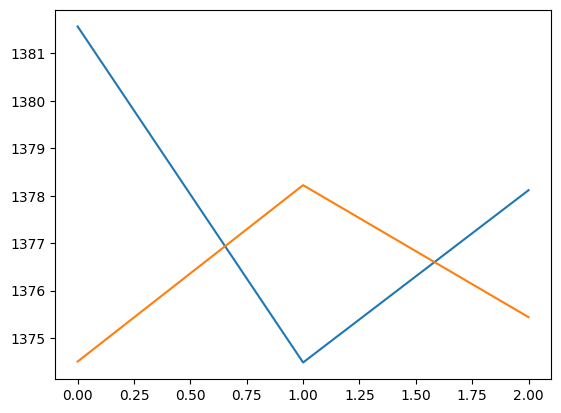

In [11]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

### For Cluster 1

In [12]:
diff_values2 = difference(raw_values2, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values2, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model, history = fit_lstm(train_scaled, 1, 10, 32)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 1ms/step


array([[ 0.03451774],
       [-0.3240776 ],
       [-0.01411402],
       [ 0.11331177],
       [-0.3118861 ],
       [-0.08193971],
       [-0.29716098],
       [ 0.01696618],
       [-0.13680089],
       [-0.09168947],
       [ 0.12655218],
       [ 0.16739447],
       [-0.16333598],
       [ 0.00311105],
       [ 0.24745223],
       [ 0.00716295],
       [ 0.09750232],
       [-0.00071083],
       [ 0.04230302],
       [ 0.04888348],
       [ 0.05153215],
       [-0.33777112],
       [-0.32353443],
       [-0.17844008],
       [-0.18356228],
       [ 0.078683  ],
       [ 0.13881229],
       [-0.10627806],
       [-0.15208255],
       [ 0.12382112],
       [ 0.58398557],
       [-0.01172842],
       [ 0.09627171],
       [-0.11479732],
       [-0.03308228],
       [-0.22010072],
       [-0.2707834 ],
       [ 0.35725963],
       [-0.00482987],
       [-0.14722155],
       [ 0.2445269 ],
       [ 0.01543496],
       [-0.13850145],
       [ 0.16183297]], dtype=float32)

In [13]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values2, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values2[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 22ms/step
Month=1, Predicted=275.680361, Expected=275.539862
1/1 [==============================] - 0s 20ms/step
Month=2, Predicted=275.370412, Expected=274.678387
1/1 [==============================] - 0s 15ms/step
Month=3, Predicted=275.072615, Expected=275.965119


Test RMSE: 0.657
Test MAE: 0.575


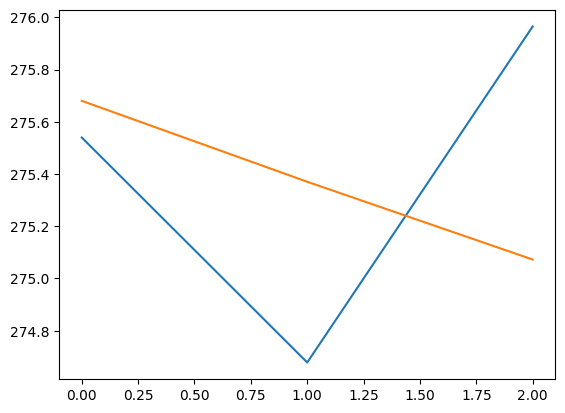

In [14]:
# report performance
rmse = sqrt(mean_squared_error(raw_values2[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values2[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values2[-3:])
pyplot.plot(predictions)
pyplot.show()

### For Cluster 2

In [15]:
diff_values3 = difference(raw_values3, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values3, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model, history = fit_lstm(train_scaled, 1, 10, 32)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 2ms/step


array([[-0.05188164],
       [-0.010692  ],
       [ 0.10001048],
       [ 0.04138233],
       [-0.09133435],
       [-0.08568279],
       [ 0.08731443],
       [-0.34647226],
       [-0.13519764],
       [ 0.13534781],
       [ 0.23296492],
       [-0.02150694],
       [-0.25532782],
       [-0.12282859],
       [-0.2160584 ],
       [-0.12453683],
       [ 0.19593436],
       [-0.09616328],
       [-0.12426043],
       [ 0.16996552],
       [-0.13610637],
       [ 0.16477434],
       [-0.36216494],
       [ 0.09655765],
       [-0.17341459],
       [ 0.04689242],
       [ 0.05668401],
       [ 0.05738181],
       [-0.10873144],
       [-0.07321295],
       [-0.07806659],
       [ 0.24913312],
       [ 0.01150126],
       [-0.31931752],
       [-0.26368505],
       [-0.2549971 ],
       [-0.12947173],
       [-0.26716653],
       [-0.09482318],
       [-0.06755294],
       [ 0.16473697],
       [-0.05789711],
       [-0.23389813],
       [-0.1249768 ]], dtype=float32)

In [16]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values3, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values3[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 18ms/step
Month=1, Predicted=2993.205195, Expected=3001.920000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=2998.948314, Expected=3009.820800
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=3003.091171, Expected=2997.898600


Test RMSE: 8.585
Test MAE: 8.260


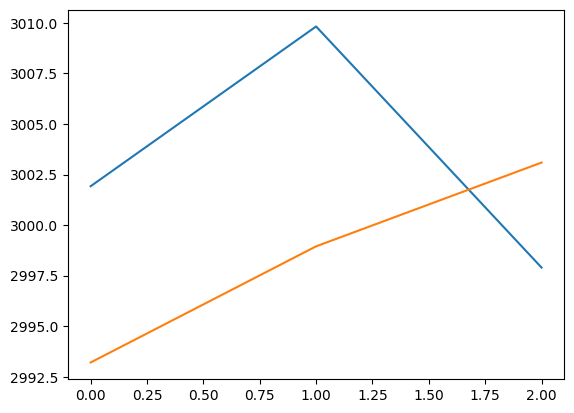

In [17]:
# report performance
rmse = sqrt(mean_squared_error(raw_values3[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values3[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values3[-3:])
pyplot.plot(predictions)
pyplot.show()

In [ ]:
pyplot.figure(figsize=(14, 5))

pyplot.subplot(1, 2, 1)
pyplot.plot(history['loss'], label='Train Loss')
# pyplot.plot(history.history['val_loss'], label='Validation Loss')
pyplot.title('Model Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend(loc='upper right')